# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [8]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

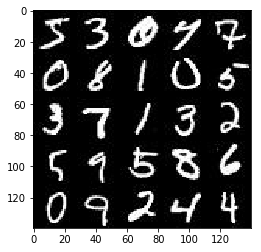

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

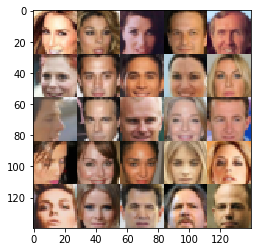

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\ProgramData\Anaconda3\envs\tensorflow1.4\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 80
    print_every = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                _ = sess.run([d_opt, g_opt], feed_dict={input_real: batch_images, input_z: batch_z, 
                                                        learn_rate: learning_rate})
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.3907... Generator Loss: 1.5393
Epoch 0/2... Discriminator Loss: 0.4287... Generator Loss: 1.5889
Epoch 0/2... Discriminator Loss: 1.2085... Generator Loss: 4.6734


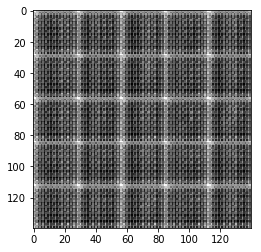

Epoch 0/2... Discriminator Loss: 0.3734... Generator Loss: 1.5157
Epoch 0/2... Discriminator Loss: 0.2839... Generator Loss: 2.0675
Epoch 0/2... Discriminator Loss: 0.3773... Generator Loss: 1.7712
Epoch 0/2... Discriminator Loss: 0.6784... Generator Loss: 1.7155


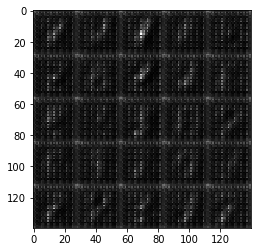

Epoch 0/2... Discriminator Loss: 1.4346... Generator Loss: 0.5403
Epoch 0/2... Discriminator Loss: 0.6056... Generator Loss: 1.7864
Epoch 0/2... Discriminator Loss: 0.6557... Generator Loss: 1.8146
Epoch 0/2... Discriminator Loss: 1.0383... Generator Loss: 0.8278


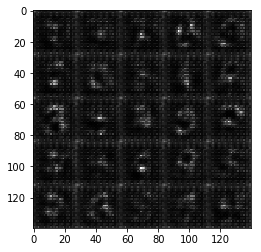

Epoch 0/2... Discriminator Loss: 1.1973... Generator Loss: 0.6664
Epoch 0/2... Discriminator Loss: 0.7875... Generator Loss: 1.6419
Epoch 0/2... Discriminator Loss: 0.8082... Generator Loss: 1.4169
Epoch 0/2... Discriminator Loss: 0.7962... Generator Loss: 1.9223


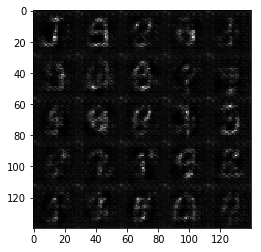

Epoch 0/2... Discriminator Loss: 0.9818... Generator Loss: 1.1885
Epoch 0/2... Discriminator Loss: 0.9735... Generator Loss: 1.0570
Epoch 0/2... Discriminator Loss: 0.9357... Generator Loss: 1.3233
Epoch 0/2... Discriminator Loss: 0.7327... Generator Loss: 1.1558


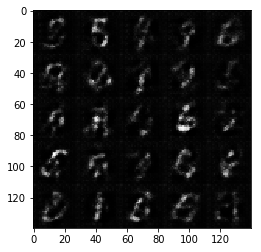

Epoch 0/2... Discriminator Loss: 1.0438... Generator Loss: 0.7270
Epoch 0/2... Discriminator Loss: 0.6798... Generator Loss: 1.5260
Epoch 0/2... Discriminator Loss: 0.6906... Generator Loss: 1.8162
Epoch 0/2... Discriminator Loss: 0.6973... Generator Loss: 1.1320


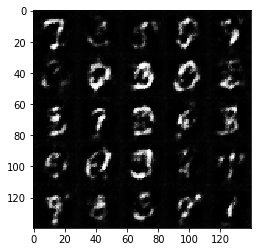

Epoch 0/2... Discriminator Loss: 0.7005... Generator Loss: 1.1617
Epoch 0/2... Discriminator Loss: 0.6248... Generator Loss: 1.8793
Epoch 0/2... Discriminator Loss: 0.6379... Generator Loss: 1.4516
Epoch 0/2... Discriminator Loss: 0.5234... Generator Loss: 1.4016


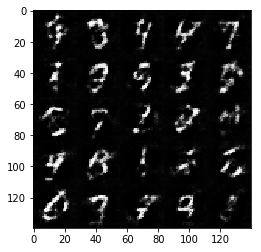

Epoch 0/2... Discriminator Loss: 1.2776... Generator Loss: 0.5614
Epoch 0/2... Discriminator Loss: 0.7793... Generator Loss: 0.9761
Epoch 0/2... Discriminator Loss: 0.4965... Generator Loss: 1.7625
Epoch 0/2... Discriminator Loss: 0.6856... Generator Loss: 2.3242


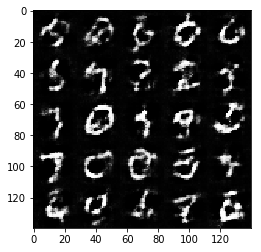

Epoch 0/2... Discriminator Loss: 0.6523... Generator Loss: 1.4410
Epoch 0/2... Discriminator Loss: 0.9625... Generator Loss: 0.7391
Epoch 0/2... Discriminator Loss: 0.6596... Generator Loss: 1.9822
Epoch 0/2... Discriminator Loss: 1.1489... Generator Loss: 0.5738


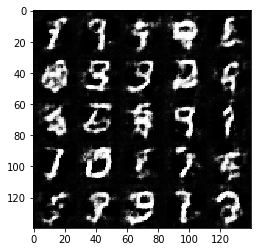

Epoch 0/2... Discriminator Loss: 0.7050... Generator Loss: 1.3130
Epoch 0/2... Discriminator Loss: 0.5324... Generator Loss: 1.4089
Epoch 0/2... Discriminator Loss: 0.6649... Generator Loss: 1.1997
Epoch 0/2... Discriminator Loss: 1.8554... Generator Loss: 0.2275


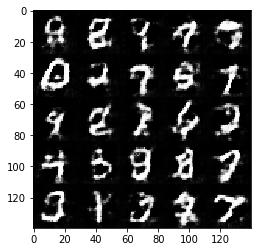

Epoch 0/2... Discriminator Loss: 0.9677... Generator Loss: 0.6984
Epoch 0/2... Discriminator Loss: 0.7999... Generator Loss: 1.0435
Epoch 0/2... Discriminator Loss: 0.5377... Generator Loss: 1.5068
Epoch 0/2... Discriminator Loss: 1.6073... Generator Loss: 0.3843


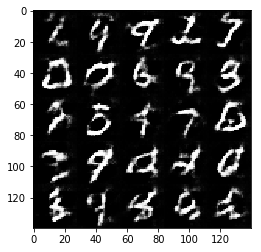

Epoch 0/2... Discriminator Loss: 0.8046... Generator Loss: 1.9330
Epoch 0/2... Discriminator Loss: 0.7787... Generator Loss: 1.7022
Epoch 0/2... Discriminator Loss: 0.7046... Generator Loss: 2.0590
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.1463


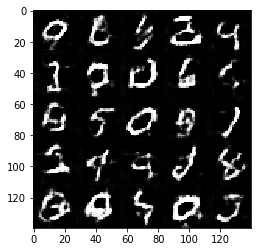

Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 1.4815


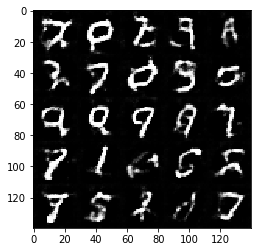

Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.9599... Generator Loss: 0.2203


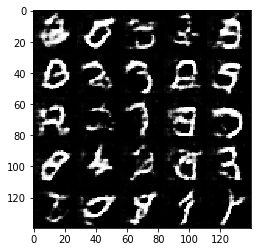

Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.4534
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.6572


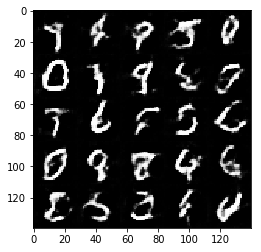

Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 2.0518


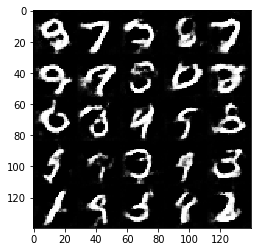

Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.4366
Epoch 1/2... Discriminator Loss: 0.6836... Generator Loss: 1.5834
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 2.6860
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 2.1128


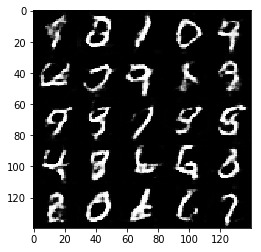

Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 1.7353
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 2.6395
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.8269


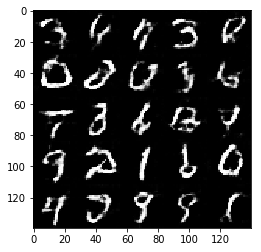

Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.3145


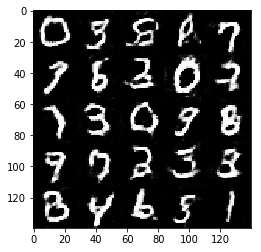

Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.5430
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 0.6590


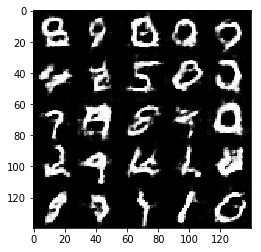

Epoch 1/2... Discriminator Loss: 2.0355... Generator Loss: 0.2055
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 1.0590
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 0.9212


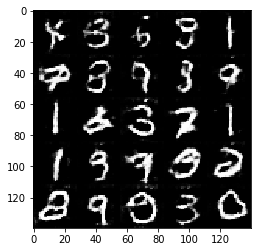

Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.1724
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 2.1120
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 0.9845


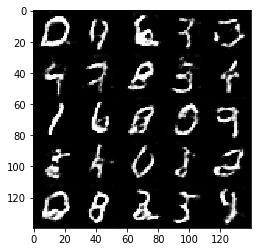

Epoch 1/2... Discriminator Loss: 0.5454... Generator Loss: 1.2767
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.8309... Generator Loss: 0.2582
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.5464


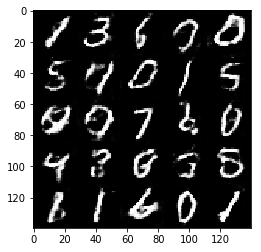

Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.6518


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.6812... Generator Loss: 1.0854
Epoch 0/1... Discriminator Loss: 0.4138... Generator Loss: 1.5682
Epoch 0/1... Discriminator Loss: 0.8064... Generator Loss: 0.7828


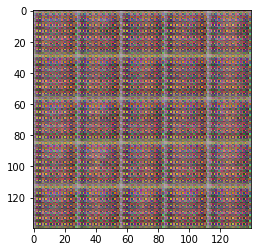

Epoch 0/1... Discriminator Loss: 0.3570... Generator Loss: 1.9802
Epoch 0/1... Discriminator Loss: 0.3600... Generator Loss: 1.9420
Epoch 0/1... Discriminator Loss: 0.3362... Generator Loss: 2.0700
Epoch 0/1... Discriminator Loss: 0.6745... Generator Loss: 1.0245


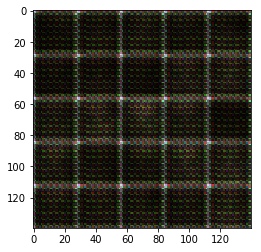

Epoch 0/1... Discriminator Loss: 0.5377... Generator Loss: 1.5364
Epoch 0/1... Discriminator Loss: 0.8378... Generator Loss: 0.9184
Epoch 0/1... Discriminator Loss: 0.6551... Generator Loss: 3.1358
Epoch 0/1... Discriminator Loss: 0.7200... Generator Loss: 1.3261


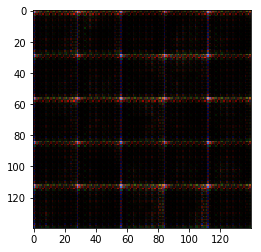

Epoch 0/1... Discriminator Loss: 0.5070... Generator Loss: 1.6313
Epoch 0/1... Discriminator Loss: 0.6479... Generator Loss: 3.3824
Epoch 0/1... Discriminator Loss: 0.9093... Generator Loss: 1.1153
Epoch 0/1... Discriminator Loss: 0.7780... Generator Loss: 1.1576


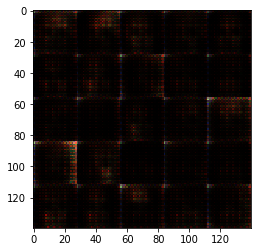

Epoch 0/1... Discriminator Loss: 0.7741... Generator Loss: 3.4412
Epoch 0/1... Discriminator Loss: 0.6126... Generator Loss: 1.6264
Epoch 0/1... Discriminator Loss: 0.6521... Generator Loss: 1.6002
Epoch 0/1... Discriminator Loss: 0.8767... Generator Loss: 1.1390


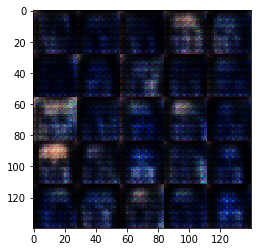

Epoch 0/1... Discriminator Loss: 1.5610... Generator Loss: 0.4453
Epoch 0/1... Discriminator Loss: 0.9937... Generator Loss: 1.1174
Epoch 0/1... Discriminator Loss: 1.0961... Generator Loss: 0.7812
Epoch 0/1... Discriminator Loss: 0.8594... Generator Loss: 0.8563


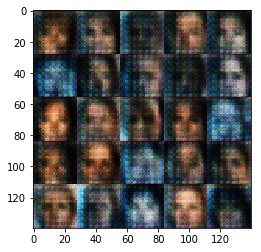

Epoch 0/1... Discriminator Loss: 0.8775... Generator Loss: 1.5625
Epoch 0/1... Discriminator Loss: 0.8479... Generator Loss: 1.5552
Epoch 0/1... Discriminator Loss: 1.2335... Generator Loss: 0.6846
Epoch 0/1... Discriminator Loss: 0.8609... Generator Loss: 1.4526


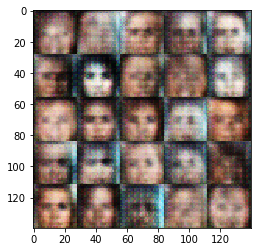

Epoch 0/1... Discriminator Loss: 0.8938... Generator Loss: 1.3149
Epoch 0/1... Discriminator Loss: 1.2965... Generator Loss: 0.5757
Epoch 0/1... Discriminator Loss: 0.9709... Generator Loss: 1.5381
Epoch 0/1... Discriminator Loss: 0.9206... Generator Loss: 1.3716


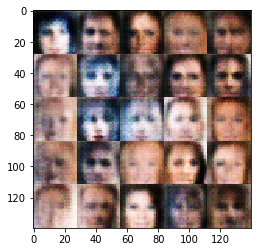

Epoch 0/1... Discriminator Loss: 1.1942... Generator Loss: 0.9940
Epoch 0/1... Discriminator Loss: 0.7483... Generator Loss: 1.2722
Epoch 0/1... Discriminator Loss: 1.0747... Generator Loss: 0.7622
Epoch 0/1... Discriminator Loss: 1.0255... Generator Loss: 0.8241


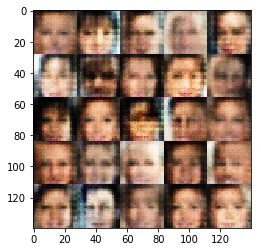

Epoch 0/1... Discriminator Loss: 1.1910... Generator Loss: 0.8766
Epoch 0/1... Discriminator Loss: 1.1398... Generator Loss: 0.7764
Epoch 0/1... Discriminator Loss: 1.1504... Generator Loss: 0.8300
Epoch 0/1... Discriminator Loss: 1.0468... Generator Loss: 0.9250


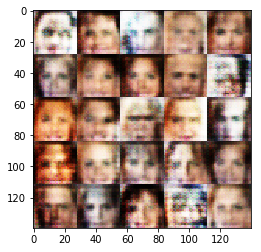

Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 0.8861
Epoch 0/1... Discriminator Loss: 1.2759... Generator Loss: 1.3317
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 1.5145
Epoch 0/1... Discriminator Loss: 1.1915... Generator Loss: 1.0894


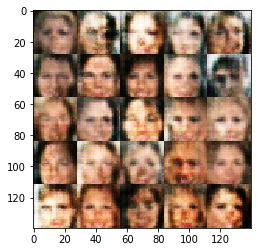

Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.7005
Epoch 0/1... Discriminator Loss: 1.1313... Generator Loss: 1.0695
Epoch 0/1... Discriminator Loss: 1.2092... Generator Loss: 0.8759
Epoch 0/1... Discriminator Loss: 1.0130... Generator Loss: 1.0130


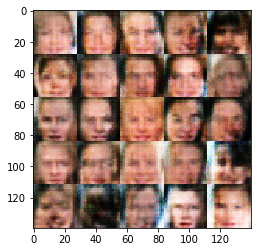

Epoch 0/1... Discriminator Loss: 1.3693... Generator Loss: 0.8077
Epoch 0/1... Discriminator Loss: 1.1389... Generator Loss: 0.7502
Epoch 0/1... Discriminator Loss: 1.1794... Generator Loss: 0.7961
Epoch 0/1... Discriminator Loss: 1.4102... Generator Loss: 0.4966


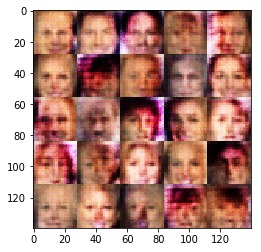

Epoch 0/1... Discriminator Loss: 1.1199... Generator Loss: 0.9393
Epoch 0/1... Discriminator Loss: 1.0750... Generator Loss: 0.8512
Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.4677
Epoch 0/1... Discriminator Loss: 0.9929... Generator Loss: 1.0774


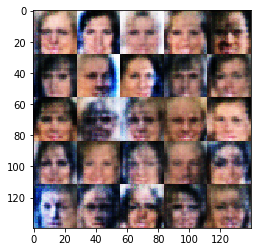

Epoch 0/1... Discriminator Loss: 0.9871... Generator Loss: 1.1023
Epoch 0/1... Discriminator Loss: 1.1332... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.1861... Generator Loss: 0.8758
Epoch 0/1... Discriminator Loss: 1.1117... Generator Loss: 0.8839


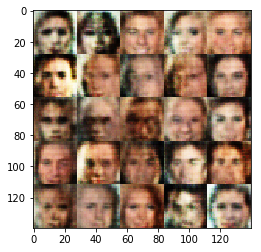

Epoch 0/1... Discriminator Loss: 1.0774... Generator Loss: 0.9110
Epoch 0/1... Discriminator Loss: 1.3456... Generator Loss: 0.5693
Epoch 0/1... Discriminator Loss: 1.1488... Generator Loss: 0.7722
Epoch 0/1... Discriminator Loss: 1.4183... Generator Loss: 0.5767


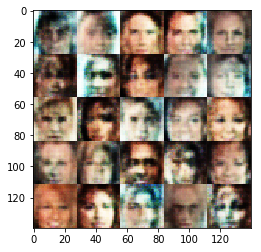

Epoch 0/1... Discriminator Loss: 1.1098... Generator Loss: 0.7610
Epoch 0/1... Discriminator Loss: 1.2944... Generator Loss: 0.8286
Epoch 0/1... Discriminator Loss: 1.1818... Generator Loss: 0.7251
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 1.1252


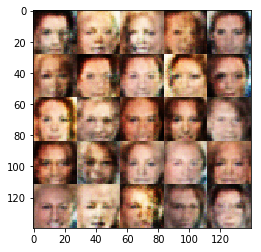

Epoch 0/1... Discriminator Loss: 1.1101... Generator Loss: 1.0072
Epoch 0/1... Discriminator Loss: 1.3002... Generator Loss: 0.7263
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.8902
Epoch 0/1... Discriminator Loss: 1.1052... Generator Loss: 0.9471


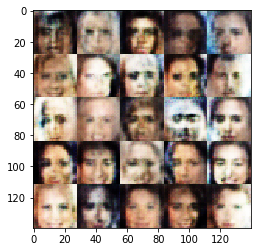

Epoch 0/1... Discriminator Loss: 1.1810... Generator Loss: 0.7142
Epoch 0/1... Discriminator Loss: 1.2863... Generator Loss: 0.7967
Epoch 0/1... Discriminator Loss: 1.1909... Generator Loss: 0.7032
Epoch 0/1... Discriminator Loss: 1.2119... Generator Loss: 0.8016


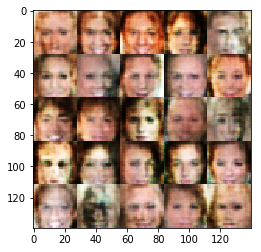

Epoch 0/1... Discriminator Loss: 1.0435... Generator Loss: 0.9263
Epoch 0/1... Discriminator Loss: 1.2685... Generator Loss: 0.8419
Epoch 0/1... Discriminator Loss: 0.9740... Generator Loss: 1.3570
Epoch 0/1... Discriminator Loss: 1.0587... Generator Loss: 0.8090


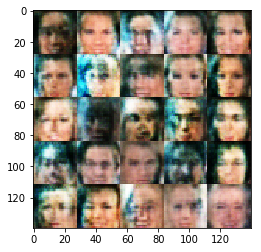

Epoch 0/1... Discriminator Loss: 1.2308... Generator Loss: 0.8511
Epoch 0/1... Discriminator Loss: 1.1731... Generator Loss: 1.1446
Epoch 0/1... Discriminator Loss: 1.5553... Generator Loss: 0.4007
Epoch 0/1... Discriminator Loss: 1.0989... Generator Loss: 1.0112


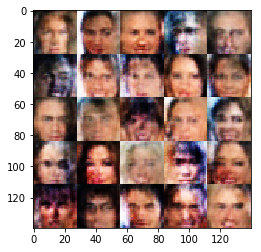

Epoch 0/1... Discriminator Loss: 1.2831... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 1.1002... Generator Loss: 0.8092
Epoch 0/1... Discriminator Loss: 0.9715... Generator Loss: 1.1795
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.6158


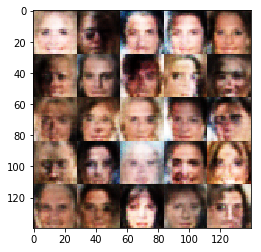

Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 1.3063
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 0.6547
Epoch 0/1... Discriminator Loss: 1.1013... Generator Loss: 0.7255
Epoch 0/1... Discriminator Loss: 1.1474... Generator Loss: 0.7464


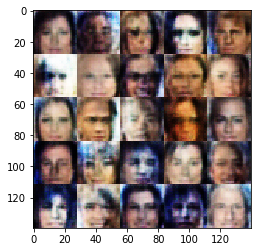

Epoch 0/1... Discriminator Loss: 1.2277... Generator Loss: 0.7761
Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 1.3049
Epoch 0/1... Discriminator Loss: 1.3051... Generator Loss: 0.7329
Epoch 0/1... Discriminator Loss: 1.2841... Generator Loss: 0.6465


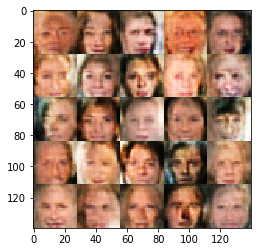

Epoch 0/1... Discriminator Loss: 1.2768... Generator Loss: 0.5556
Epoch 0/1... Discriminator Loss: 1.1260... Generator Loss: 1.0190
Epoch 0/1... Discriminator Loss: 1.1219... Generator Loss: 0.8790
Epoch 0/1... Discriminator Loss: 1.1707... Generator Loss: 0.6705


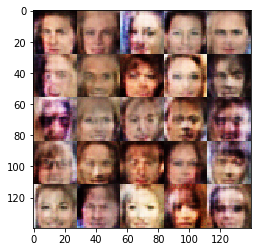

Epoch 0/1... Discriminator Loss: 1.3121... Generator Loss: 0.9095
Epoch 0/1... Discriminator Loss: 1.2449... Generator Loss: 0.9313
Epoch 0/1... Discriminator Loss: 1.0676... Generator Loss: 0.6892
Epoch 0/1... Discriminator Loss: 0.8339... Generator Loss: 1.1488


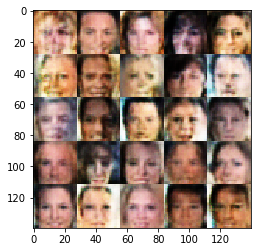

Epoch 0/1... Discriminator Loss: 1.2118... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 1.0949... Generator Loss: 0.9975
Epoch 0/1... Discriminator Loss: 1.2588... Generator Loss: 1.1786
Epoch 0/1... Discriminator Loss: 0.9594... Generator Loss: 0.9356


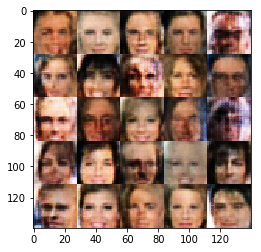

Epoch 0/1... Discriminator Loss: 1.2867... Generator Loss: 0.6717
Epoch 0/1... Discriminator Loss: 1.1479... Generator Loss: 0.7237
Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 1.0435
Epoch 0/1... Discriminator Loss: 1.2108... Generator Loss: 0.6199


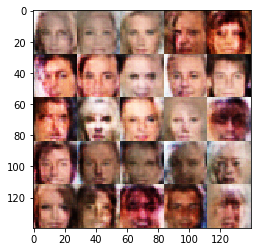

Epoch 0/1... Discriminator Loss: 1.2290... Generator Loss: 0.7513
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 0.7445
Epoch 0/1... Discriminator Loss: 1.1584... Generator Loss: 0.7786
Epoch 0/1... Discriminator Loss: 0.9644... Generator Loss: 0.8767


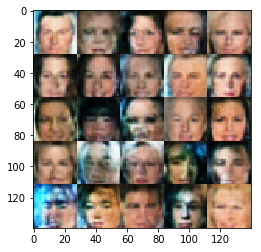

Epoch 0/1... Discriminator Loss: 1.4669... Generator Loss: 0.4963
Epoch 0/1... Discriminator Loss: 0.9019... Generator Loss: 0.8804
Epoch 0/1... Discriminator Loss: 1.1748... Generator Loss: 0.8792
Epoch 0/1... Discriminator Loss: 0.7868... Generator Loss: 1.2049


Epoch 0/1... Discriminator Loss: 1.2989... Generator Loss: 0.9652
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 0.7851
Epoch 0/1... Discriminator Loss: 0.7193... Generator Loss: 1.5968
Epoch 0/1... Discriminator Loss: 1.5456... Generator Loss: 0.6371


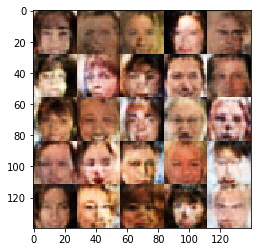

Epoch 0/1... Discriminator Loss: 1.1029... Generator Loss: 0.7608
Epoch 0/1... Discriminator Loss: 1.2462... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 0.8087
Epoch 0/1... Discriminator Loss: 1.3035... Generator Loss: 0.5415


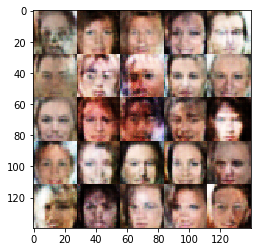

Epoch 0/1... Discriminator Loss: 1.0722... Generator Loss: 0.7910
Epoch 0/1... Discriminator Loss: 0.9623... Generator Loss: 0.9179
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.4728
Epoch 0/1... Discriminator Loss: 1.8859... Generator Loss: 0.3220


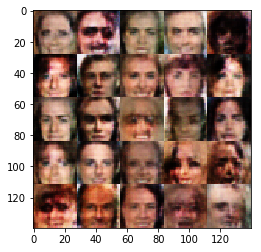

Epoch 0/1... Discriminator Loss: 1.5081... Generator Loss: 0.5005
Epoch 0/1... Discriminator Loss: 0.7200... Generator Loss: 1.2157
Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 0.8054... Generator Loss: 1.2202


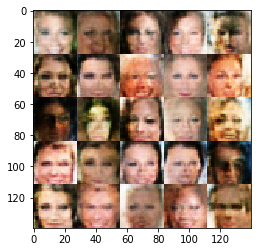

Epoch 0/1... Discriminator Loss: 1.2774... Generator Loss: 0.6430
Epoch 0/1... Discriminator Loss: 1.1326... Generator Loss: 0.7769
Epoch 0/1... Discriminator Loss: 1.2519... Generator Loss: 0.6759
Epoch 0/1... Discriminator Loss: 1.0470... Generator Loss: 1.0401


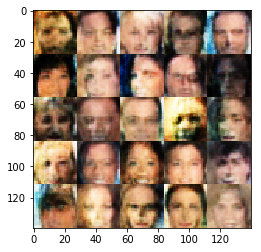

Epoch 0/1... Discriminator Loss: 1.2463... Generator Loss: 0.5296
Epoch 0/1... Discriminator Loss: 1.3297... Generator Loss: 0.7411
Epoch 0/1... Discriminator Loss: 1.7996... Generator Loss: 0.3513
Epoch 0/1... Discriminator Loss: 1.1256... Generator Loss: 1.1911


Epoch 0/1... Discriminator Loss: 0.8813... Generator Loss: 1.1616
Epoch 0/1... Discriminator Loss: 0.8414... Generator Loss: 1.1679
Epoch 0/1... Discriminator Loss: 0.9787... Generator Loss: 0.9403
Epoch 0/1... Discriminator Loss: 0.8911... Generator Loss: 0.9376


Epoch 0/1... Discriminator Loss: 1.1497... Generator Loss: 0.6837
Epoch 0/1... Discriminator Loss: 0.8376... Generator Loss: 1.4239
Epoch 0/1... Discriminator Loss: 1.4384... Generator Loss: 0.5678
Epoch 0/1... Discriminator Loss: 1.0041... Generator Loss: 0.7966


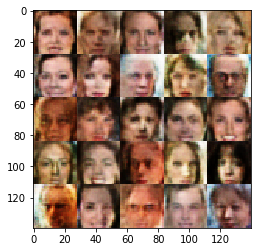

Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.8455
Epoch 0/1... Discriminator Loss: 1.2691... Generator Loss: 0.5778
Epoch 0/1... Discriminator Loss: 1.0414... Generator Loss: 0.9107
Epoch 0/1... Discriminator Loss: 1.1537... Generator Loss: 0.7936


Epoch 0/1... Discriminator Loss: 0.8210... Generator Loss: 1.1680
Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 0.9848
Epoch 0/1... Discriminator Loss: 1.5205... Generator Loss: 0.4833


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.